In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import zipfile
import cv2

In [47]:
from keras.layers import Input, Lambda
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization


In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d dhruvildave/english-handwritten-characters-dataset

english-handwritten-characters-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!ls

english-handwritten-characters-dataset.zip  files  kaggle.json	sample_data


In [9]:
zip_ref = zipfile.ZipFile('english-handwritten-characters-dataset.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [10]:
df = pd.read_csv('/content/files/english.csv')

In [11]:
df.head()

,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0


In [12]:
#Shuffle the dataset
df = df.sample(frac =1 )

In [13]:
df.head()

,image,label
2729,Img/img050-035.png,n
1215,Img/img023-006.png,M
3174,Img/img058-040.png,v
3092,Img/img057-013.png,u
3056,Img/img056-032.png,t


In [14]:
df.shape

(3410, 2)

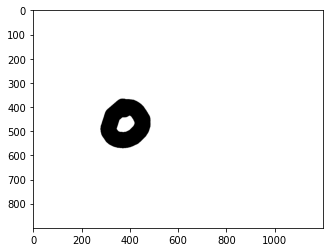

In [15]:
base_path = '/content/files/'
image = cv2.imread(base_path + df['image'][10])
plt.imshow(image)

# Building a CNN Model


In [16]:
#Define the image dimensions and channel
img_width = 128
img_height = 128
img_size = (img_width, img_height)
img_channel = 1
batch_size=15
epochs = 30

## Define Model

In [17]:

model = Sequential()

model.add(Conv2D(32, (3, 3), activation= 'relu', input_shape = (img_width, img_height, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(62, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [18]:
#train Test Split the data
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size = 0.20, random_state = 42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop = True)


In [19]:
print(train_df.shape)
print(test_df.shape)

(2728, 2)
(682, 2)


## Data Augmentation

In [20]:
#Create Genrator for Train data
from keras.preprocessing.image import ImageDataGenerator, load_img
datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    validation_split = 0.20
)

train_genrator = datagen.flow_from_dataframe(
    train_df, 
    base_path,
    x_col = 'image',
    color_mode='grayscale',
    subset = 'training',
    y_col = 'label',
    target_size = img_size,
    batch_size = 20,
    class_mode = 'categorical'
)

valid_genrator = datagen.flow_from_dataframe(
    train_df, 
    base_path,
    x_col = 'image',
    y_col = 'label',
    color_mode='grayscale',
    subset = 'validation',
    target_size = img_size,
    batch_size = 20,
    class_mode = 'categorical'

)

Found 2183 validated image filenames belonging to 62 classes.
Found 545 validated image filenames belonging to 62 classes.


In [21]:
#Create Genrator for test Data 
test_datagen = ImageDataGenerator( #Do data augmentation
   rescale = 1./255
)

test_genrator = test_datagen.flow_from_dataframe(
    test_df, 
    base_path,
    x_col = 'image',
    y_col = None,
    color_mode='grayscale',
    target_size = img_size,
    batch_size = 20,
    class_mode = None
)

Found 682 validated image filenames.


## Training and Prediction

In [23]:

history = model.fit_generator(
    train_genrator,
    epochs = epochs,
    validation_data = valid_genrator,
    verbose = 1
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
110/110 [==============================] - 41s 344ms/step - loss: 4.3683 - accuracy: 0.0975 - val_loss: 5.1955 - val_accuracy: 0.0147
Epoch 2/30
110/110 [==============================] - 37s 341ms/step - loss: 3.0583 - accuracy: 0.2520 - val_loss: 5.3575 - val_accuracy: 0.0239
Epoch 3/30
110/110 [==============================] - 38s 342ms/step - loss: 2.2333 - accuracy: 0.4164 - val_loss: 62.9017 - val_accuracy: 0.0220
Epoch 4/30
110/110 [==============================] - 38s 343ms/step - loss: 1.7889 - accuracy: 0.5322 - val_loss: 130.1436 - val_accuracy: 0.0239
Epoch 5/30
110/110 [==============================] - 38s 343ms/step - loss: 1.4939 - accuracy: 0.6113 - val_loss: 63.8983 - val_accuracy: 0.0202
Epoch 6/30
110/110 [==============================] - 39s 354ms/step - loss: 1.3201 - accuracy: 0.6296 - val_loss: 1.8377 - val_accuracy: 0.5266
Epoch 7/30
110/110 [==============================] - 39s 352ms/step - loss: 1.0536 - accuracy: 0.7143 - val_loss: 946.7203 - 

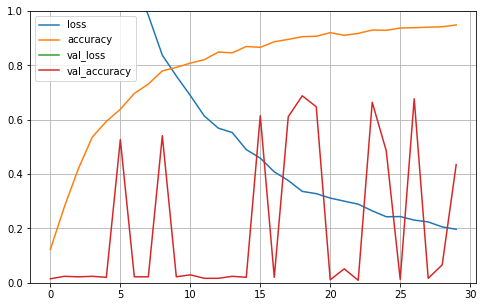

In [24]:

#Print statistics graph 
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [32]:
from keras.preprocessing.image import load_img, img_to_array
matrix = []
for i in range(len(test_df)):
  test_image = load_img(base_path + test_df['image'][i], target_size = [128, 128], grayscale= True)
  test_image = img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  test_image = test_image/255
  predict = model.predict_generator(test_image)
  matrix.append(predict)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [33]:
#Pick category with maximum probability
import numpy as np

test_df['category'] = np.argmax(matrix, axis = -1) 

In [34]:
test_df.head()

,image,label,category
0,Img/img033-048.png,W,58
1,Img/img021-025.png,K,20
2,Img/img056-043.png,t,17
3,Img/img036-042.png,Z,35
4,Img/img023-052.png,M,22


In [35]:
#Conver category into label using train_genrator.class_indices

label_map = dict((v,k) for k,v in train_genrator.class_indices.items())
test_df['category2'] = test_df['category'].replace(label_map)

In [36]:
test_df

,image,label,category,category2
0,Img/img033-048.png,W,58,w
1,Img/img021-025.png,K,20,K
2,Img/img056-043.png,t,17,H
3,Img/img036-042.png,Z,35,Z
4,Img/img023-052.png,M,22,M
...,...,...,...,...
677,Img/img002-049.png,1,54,s
678,Img/img001-018.png,0,10,A
679,Img/img019-033.png,I,18,I
680,Img/img023-050.png,M,22,M


In [37]:
def acc(y_true, y_pred):
    return np.equal((y_true), (y_pred)).mean()

print("accuracy: " + str(acc(test_df['label'], test_df['category2'])))

accuracy: 0.46920821114369504


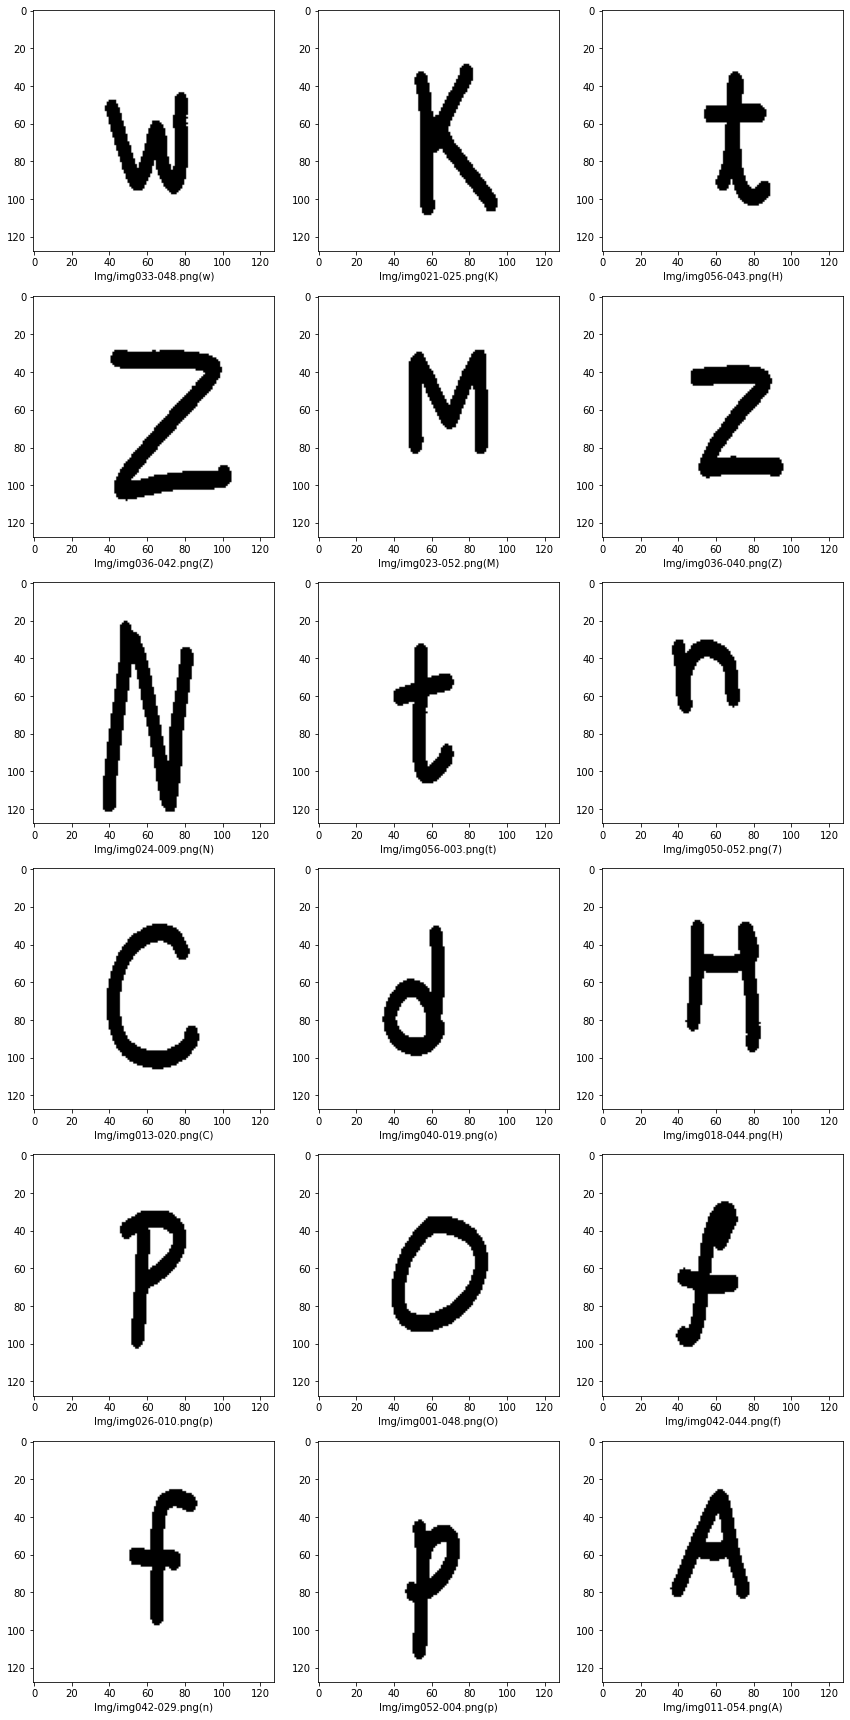

In [39]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['image']
    category = row['category2']
    img = load_img(base_path+filename, target_size=img_size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Using VGG16Net

In [40]:
#Define the image dimensions and channel
img_width = 224
img_height = 224
img_size = [img_width, img_height]
img_channel = 3

In [41]:
#train Test Split the data
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size = 0.10, random_state = 42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop = True)


In [42]:
print(train_df.shape)
print(test_df.shape)

(3069, 2)
(341, 2)


## Augmentation

In [75]:
#Create Genrator for Train data
from keras.preprocessing.image import ImageDataGenerator, load_img

datagen=ImageDataGenerator(rescale=1./255.,
                           rotation_range = 15, 
                           validation_split=0.25,
                           horizontal_flip=True)


train_genrator = datagen.flow_from_dataframe(
    train_df, 
    base_path,
    x_col = 'image',
    #color_mode='rgb',
    subset="training",
    y_col = 'label',
    target_size = img_size,
    batch_size = 32,
    class_mode = 'categorical'
)

valid_genrator = datagen.flow_from_dataframe(
    train_df, 
    base_path,
    x_col = 'image',
    y_col = 'label',
    subset="validation",
    #color_mode='rgb',
    target_size = img_size,
    batch_size = 32,
    class_mode = 'categorical'

)

Found 2302 validated image filenames belonging to 62 classes.
Found 767 validated image filenames belonging to 62 classes.


In [76]:
#Create Genrator for test Data 
test_datagen = ImageDataGenerator( 
    rescale = 1./255
)

test_genrator = test_datagen.flow_from_dataframe(
    test_df, 
    base_path,
    x_col = 'image',
    y_col = None,
    #color_mode='rgb',
    target_size = img_size,
    #batch_size = 32,
    class_mode = None
)

Found 341 validated image filenames.


## Model

In [77]:
vgg = VGG16(input_shape= img_size + [3], weights= 'imagenet', include_top= False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [78]:
#let’s makes the middle layers freeze.
for layer in vgg.layers:
  layer.trainable = False
#We have already removed the output layer by include_top = False.

In [79]:
x = Flatten()(vgg.output)
prediction = Dense(62, activation='sigmoid')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [80]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

In [94]:
history = model.fit_generator(
    train_genrator,
    epochs = 30,
     verbose = 1,
     validation_data = valid_genrator
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
72/72 [==============================] - 63s 870ms/step - loss: 0.6164 - accuracy: 0.8202 - val_loss: 0.9483 - val_accuracy: 0.7197
Epoch 2/30
72/72 [==============================] - 62s 859ms/step - loss: 0.5937 - accuracy: 0.8306 - val_loss: 0.9460 - val_accuracy: 0.7405
Epoch 3/30
72/72 [==============================] - 62s 860ms/step - loss: 0.6004 - accuracy: 0.8280 - val_loss: 0.8818 - val_accuracy: 0.7523
Epoch 4/30
72/72 [==============================] - 62s 862ms/step - loss: 0.5790 - accuracy: 0.8301 - val_loss: 0.8807 - val_accuracy: 0.7340
Epoch 5/30
72/72 [==============================] - 61s 854ms/step - loss: 0.5554 - accuracy: 0.8345 - val_loss: 0.8451 - val_accuracy: 0.7666
Epoch 6/30
72/72 [==============================] - 61s 850ms/step - loss: 0.5714 - accuracy: 0.8367 - val_loss: 0.9069 - val_accuracy: 0.7419
Epoch 7/30
72/72 [==============================] - 61s 848ms/step - loss: 0.5652 - accuracy: 0.8328 - val_loss: 0.8582 - val_accuracy: 0.7405

## Graph and Predictions

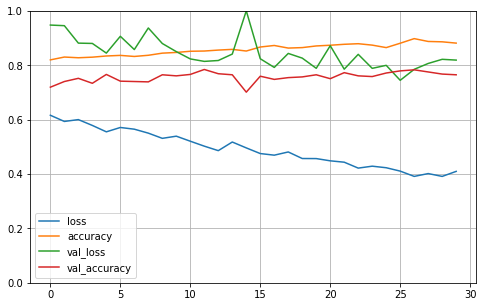

In [95]:

#Print statistics graph 
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [96]:
from keras.preprocessing.image import load_img, img_to_array
matrix = []
for i in range(len(test_df)):
  test_image = load_img(base_path + test_df['image'][i], target_size = [224,224])
  test_image = img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  test_image = test_image/255
  predict = model.predict_generator(test_image)
  matrix.append(predict)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [97]:
test_df['category'] = np.argmax(matrix, axis = -1) 


test_df


,image,label,category,category2
0,Img/img033-048.png,W,32,w
1,Img/img021-025.png,K,20,K
2,Img/img056-043.png,t,55,t
3,Img/img036-042.png,Z,35,Z
4,Img/img023-052.png,M,22,M
...,...,...,...,...
336,Img/img055-012.png,s,57,z
337,Img/img007-032.png,6,6,6
338,Img/img003-004.png,2,2,2
339,Img/img056-044.png,t,55,t


In [98]:
labels = (train_genrator.class_indices)
labels = dict((v,k) for k,v in labels.items())
test_df['category2'] = [labels[k] for k in test_df['category']]

In [99]:
test_df

,image,label,category,category2
0,Img/img033-048.png,W,32,W
1,Img/img021-025.png,K,20,K
2,Img/img056-043.png,t,55,t
3,Img/img036-042.png,Z,35,Z
4,Img/img023-052.png,M,22,M
...,...,...,...,...
336,Img/img055-012.png,s,57,v
337,Img/img007-032.png,6,6,6
338,Img/img003-004.png,2,2,2
339,Img/img056-044.png,t,55,t


In [100]:
#Accuracy
def acc(y_true, y_pred):
    return np.equal((y_true), (y_pred)).mean()

print("accuracy: " + str(acc(test_df['label'], test_df['category2'])))

accuracy: 0.7624633431085044


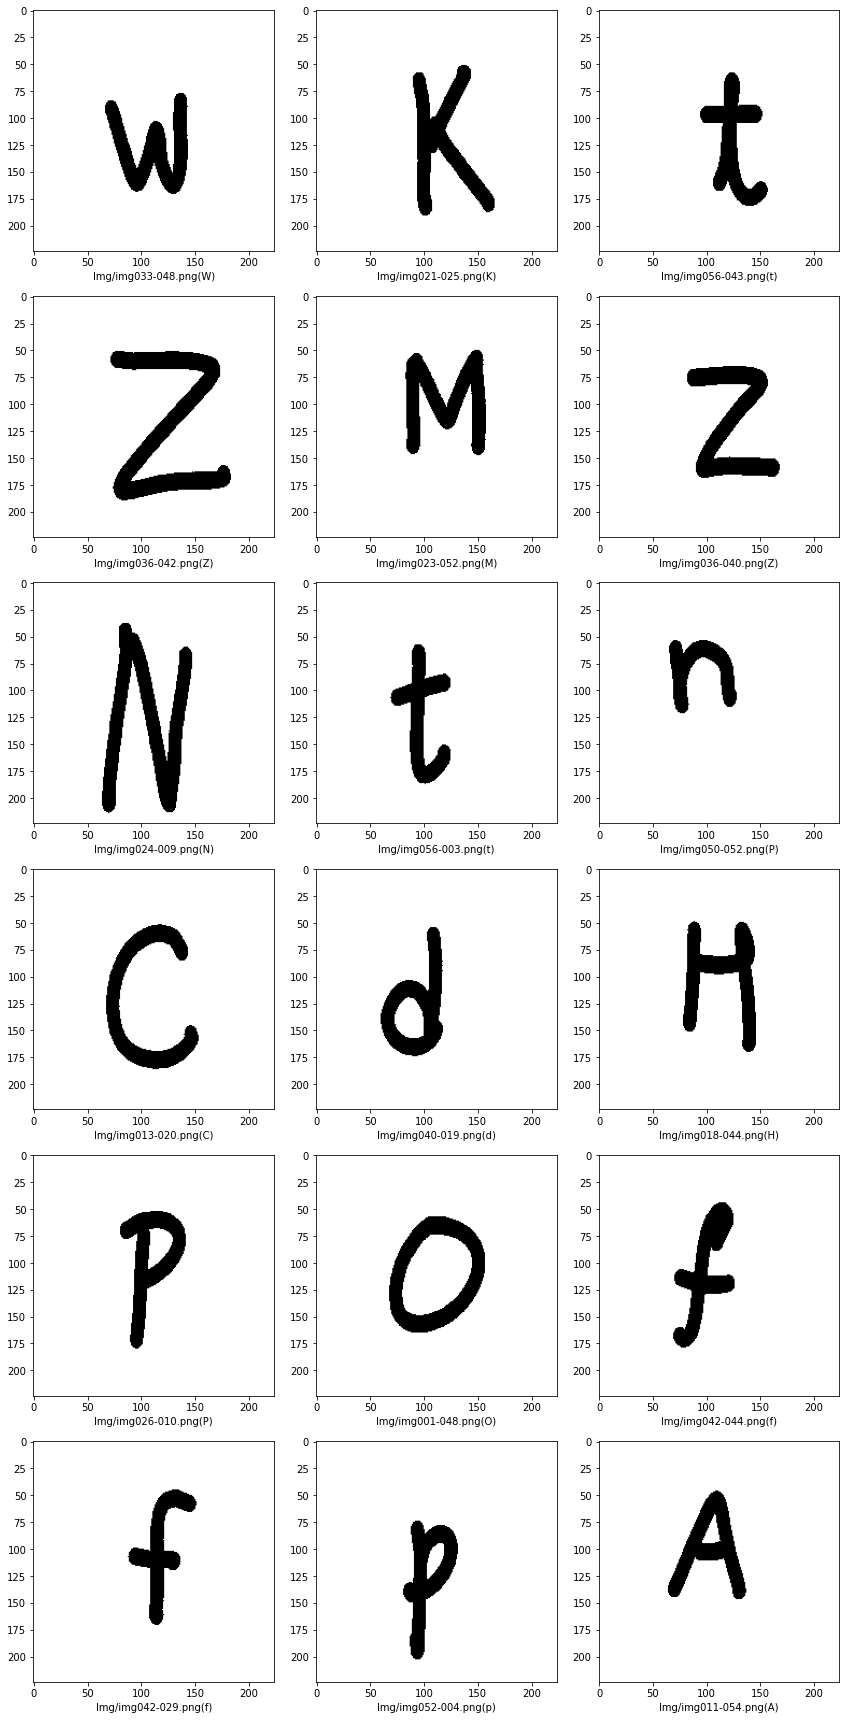

In [101]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['image']
    category = row['category2']
    img = load_img(base_path+filename, target_size=img_size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()